<a href="https://colab.research.google.com/github/Ea-mjolnir/Deep-Learning-Scripts/blob/main/Point2Roof_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from sklearn.cluster import DBSCAN
import numpy as np

# PointNet++ Encoder-Decoder
class PointNetPP(tf.keras.Model):
    def __init__(self):
        super(PointNetPP, self).__init__()
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
        ])
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu')  # Point-wise features
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded  # Point-wise features

# Offset Regression Module
class OffsetRegression(tf.keras.Model):
    def __init__(self):
        super(OffsetRegression, self).__init__()
        self.layers_ = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3)  # Predict x, y, z offset
        ])

    def call(self, inputs):
        return self.layers_(inputs)

# Binary Classification Module
class PointBinaryClassifier(tf.keras.Model):
    def __init__(self):
        super(PointBinaryClassifier, self).__init__()
        self.layers_ = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
        ])

    def call(self, inputs):
        return self.layers_(inputs)

# Paired Point Attention (PPA) Module
class PPAModule(tf.keras.Model):
    def __init__(self):
        super(PPAModule, self).__init__()
        self.attention = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Attention score
        ])

    def call(self, vertex_features):
        n = tf.shape(vertex_features)[0]
        edges = []
        for i in range(n):
            for j in range(i + 1, n):
                # Concatenate feature pairs
                edge_input = tf.concat([vertex_features[i], vertex_features[j]], axis=0)
                attention_score = self.attention(edge_input[tf.newaxis, :])
                edges.append(attention_score * edge_input)
        return tf.stack(edges)

# Edge Prediction Module
class EdgePrediction(tf.keras.Model):
    def __init__(self):
        super(EdgePrediction, self).__init__()
        self.layers_ = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Edge probability
        ])

    def call(self, inputs):
        return self.layers_(inputs)

# Main Point2Roof Model
class Point2Roof(tf.keras.Model):
    def __init__(self):
        super(Point2Roof, self).__init__()
        self.pointnetpp = PointNetPP()
        self.offset_regression = OffsetRegression()
        self.binary_classifier = PointBinaryClassifier()
        self.ppa_module = PPAModule()
        self.edge_prediction = EdgePrediction()

    def call(self, point_cloud):
        # Pass through PointNet++
        point_features = self.pointnetpp(point_cloud)

        # Predict vertex candidates and offsets
        vertex_candidates = self.binary_classifier(point_features)
        offsets = self.offset_regression(point_features)

        # Adjust vertex positions using offsets
        adjusted_vertices = point_cloud + offsets

        # Cluster vertices using DBSCAN
        clusters = self.cluster_vertices(adjusted_vertices.numpy(), vertex_candidates.numpy())

        # Extract vertex features for PPA
        vertex_features = tf.gather(point_features, clusters)

        # Predict edges using Paired Point Attention and Edge Prediction
        edge_features = self.ppa_module(vertex_features)
        edges = self.edge_prediction(edge_features)

        return adjusted_vertices, edges

    @staticmethod
    def cluster_vertices(vertices, probabilities, eps=0.5, min_samples=2):
        # Filter points with high vertex probability
        high_prob_points = vertices[probabilities.squeeze() > 0.5]

        # Fallback if no points pass the threshold
        if high_prob_points.shape[0] == 0:
            # If no high-probability points, take the top-k highest probability points
            top_k = min(10, len(probabilities))  # Ensure at least 10 points
            top_indices = tf.argsort(probabilities[:, 0], direction='DESCENDING')[:top_k]
            high_prob_points = tf.gather(vertices, top_indices)

        # Run DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(high_prob_points)
        return clustering.labels_

# Roof Model Construction (Placeholder)
def construct_roof(vertices, edges):
    # Placeholder for roof model construction logic
    pass




Vertex Scores (first 10): [[0.503336  ]
 [0.50361335]
 [0.5087342 ]
 [0.5032054 ]
 [0.5008036 ]
 [0.5062413 ]
 [0.50512815]
 [0.50273424]
 [0.5048679 ]
 [0.4989872 ]]
Number of points above threshold (0.3): 1000


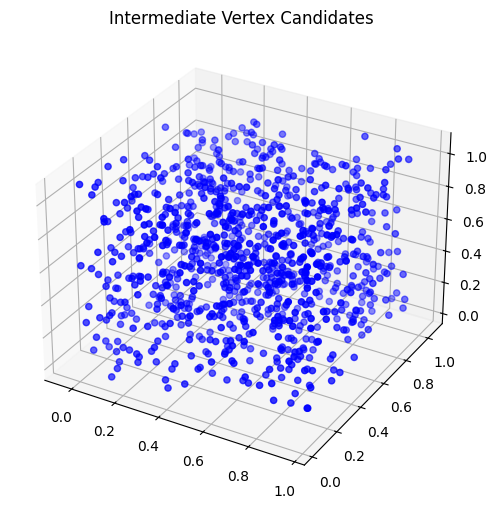

Cluster Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

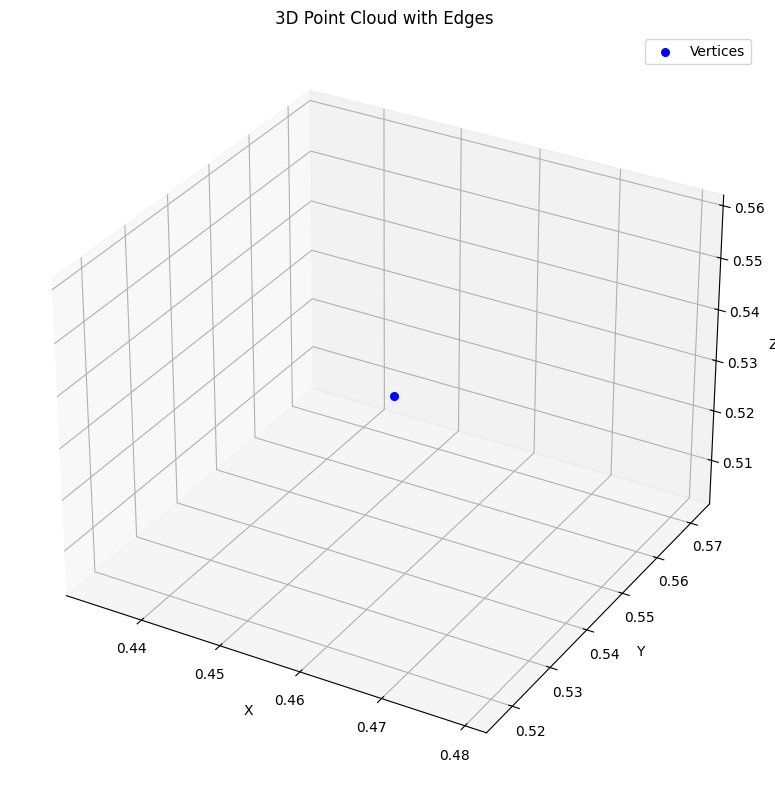

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN


# Define the Point2Roof model
class Point2Roof(tf.keras.Model):
    def __init__(self):
        super(Point2Roof, self).__init__()
        self.pointnet_encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu')
        ])
        self.pointnet_decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3, activation='linear')  # Predict offsets
        ])
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
        self.offset_regressor = tf.keras.layers.Dense(3)  # Offset prediction

    def call(self, inputs):
        # PointNet++ encoder-decoder for feature extraction
        point_features = self.pointnet_encoder(inputs)
        decoded_features = self.pointnet_decoder(point_features)

        # Binary classification for vertex detection
        vertex_scores = self.classifier(decoded_features)
        print("Vertex Scores (first 10):", vertex_scores.numpy()[:10])  # Debug: Print vertex scores

        # Offset regression for precise vertex location
        offsets = self.offset_regressor(decoded_features)
        predicted_vertices = inputs + offsets

        # Retain points with classification scores > 0.3 (lowered threshold)
        score_threshold = 0.3
        high_score_indices = np.where(vertex_scores.numpy() > score_threshold)[0]
        vertex_candidates = predicted_vertices.numpy()[high_score_indices]
        print(f"Number of points above threshold ({score_threshold}): {len(vertex_candidates)}")  # Debug

        # Visualize the vertex candidates
        if len(vertex_candidates) > 0:
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(vertex_candidates[:, 0], vertex_candidates[:, 1], vertex_candidates[:, 2], c='blue', s=20)
            ax.set_title("Intermediate Vertex Candidates")
            plt.show()

        # If no vertices are detected, return empty arrays
        if len(vertex_candidates) == 0:
            return np.empty((0, 3)), np.empty((0, 2))

        # Cluster using DBSCAN to refine vertices
        dbscan = DBSCAN(eps=1.0, min_samples=1)  # Adjusted DBSCAN parameters
        clusters = dbscan.fit(vertex_candidates)

        # Debugging: Print cluster labels
        print("Cluster Labels:", clusters.labels_)

        # Refine vertices by taking the mean of each cluster
        refined_vertices = np.array([
            vertex_candidates[clusters.labels_ == i].mean(axis=0)
            for i in range(max(clusters.labels_) + 1)
        ])
        print(f"Refined Vertices: {len(refined_vertices)}")  # Debug

        # Generate edges by connecting vertices (example: nearest neighbor connections)
        num_vertices = refined_vertices.shape[0]
        edges = []
        for i in range(num_vertices):
            for j in range(i + 1, num_vertices):  # Connect every pair of vertices
                edges.append((i, j))
        edges = np.array(edges)

        return refined_vertices, edges


# Visualization function
def visualize_point_cloud_with_edges(vertices, edges):
    """
    Visualize the 3D vertices and edges with interactive zoom and rotation.

    Args:
        vertices (np.ndarray): Array of vertex coordinates (N, 3).
        edges (np.ndarray): Array of edges, where each row represents a pair of vertex indices (M, 2).
    """
    vertices = np.array(vertices)
    edges = np.array(edges)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='blue', s=30, label='Vertices')

    # Plot edges
    for edge in edges:
        start, end = edge
        ax.plot(
            [vertices[start, 0], vertices[end, 0]],
            [vertices[start, 1], vertices[end, 1]],
            [vertices[start, 2], vertices[end, 2]],
            c='red',
            linewidth=1.5,
            alpha=0.8
        )

    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Point Cloud with Edges")
    ax.legend()

    # Enable interactive mode
    plt.tight_layout()
    plt.show()


# Main execution
if __name__ == "__main__":
    # Generate random point cloud for testing
    point_cloud = tf.random.uniform((1000, 3))  # Generate 1000 points for input

    # Initialize the Point2Roof model
    model = Point2Roof()

    # Forward pass through the model
    vertices, edges = model(point_cloud)

    # Debugging: Print detected vertices and edges
    if vertices.shape[0] < 50:
        print(f"Warning: Only {vertices.shape[0]} vertices detected. Check the classification threshold or clustering.")
    else:
        print(f"Successfully detected {vertices.shape[0]} vertices and {edges.shape[0]} edges.")

    print("Vertices:", vertices)
    print("Edges:", edges)

    # Visualize the output
    visualize_point_cloud_with_edges(vertices, edges)

